# Cointegration Matrix

### Modules

In [1]:
import numpy as np
import pandas as pd
import math

import statsmodels
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.api as stat
import statsmodels.tsa.stattools as ts

import matplotlib.pyplot as plt
from datetime import datetime, date

import seaborn as sb
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

### Import Data

In [4]:
# Import Data
assets = ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'XRPUSDT', 'LUNAUSDT', 'SOLUSDT', 'ADAUSDT', 'DOTUSDT', 'AVAXUSDT', 'DOGEUSDT', '1000SHIBUSDT', 'MATICUSDT', 'ATOMUSDT', 'LTCUSDT', 'NEARUSDT', 'TRXUSDT', 'LINKUSDT', 'BCHUSDT', 'ALGOUSDT', 'XLMUSDT', 'UNIUSDT', 'AXSUSDT', 'MANAUSDT', 'ETCUSDT', 'XMRUSDT', 'EGLDUSDT', 'SANDUSDT', 'FILUSDT', 'FTMUSDT', 'EOSUSDT', 'ZECUSDT', 'AAVEUSDT', 'COMPUSDT', 'MKRUSDT', 'YFIUSDT', 'YFIIUSDT']
#assets = ['BTCUSDT', 'ETHUSDT', 'ZECUSDT', 'XMRUSDT', 'LTCUSDT', 'ETCUSDT', 'YFIUSDT', 'YFIIUSDT', 'XRPUSDT', 'ADAUSDT', 'ZENUSDT', 'DASHUSDT']
data = {}
prices_1h = {}

for asset in assets:
    data[asset] = pd.read_csv('./{}_1h.csv'.format(asset), index_col=0)
    data[asset].iloc[:,0] = pd.to_datetime(data[asset].iloc[:,0], unit='ms')
    prices_1h[asset] = pd.DataFrame({'date': data[asset].iloc[:,0], 'price': data[asset].iloc[:,3]})
    prices_1h[asset]['log_price'] = prices_1h[asset]['price'].apply(lambda x: math.log(x))


### Functions

In [5]:
# Functions
def engle_granger_coint(A, B):
    result = stat.OLS(A, B).fit()
    a = ts.adfuller(result.resid)
    pvalue = a[1]
    return pvalue, result.params[0]


def johansen_coint(A, B):
    df = pd.DataFrame({'x': A, 'y': B})
    jres = coint_johansen(df, 0, 1)
    return jres.max_eig_stat[0], jres.max_eig_stat_crit_vals[0], jres.evec[0]


def cointegration(coint_type, confidence_interval, data_A, data_B):
    
    # Make data same size
    length_A = len(data_A)
    length_B = len(data_B)
    if length_A > length_B:
        data_A = data_A[(length_A-length_B):]
    elif length_B > length_A:
        data_B = data_B[(length_B-length_A):]
    
    data_A = list(data_A)
    data_B = list(data_B)
    
    if coint_type == 'engle-granger':
        pvalue, beta = engle_granger_coint(data_A, data_B)
        cointegrated = pvalue <= 1 - confidence_interval
        return cointegrated, pvalue, beta

    elif coint_type == 'johansen':
        max_eig_value, max_eig_crit_val, eigenvectors = johansen_coint(data_A, data_B)
        if confidence_interval == 0.9:
            cointegrated = max_eig_value > max_eig_crit_val[0]
        elif confidence_interval == 0.95:
            cointegrated = max_eig_value > max_eig_crit_val[1]
        elif confidence_interval == 0.99:
            cointegrated = max_eig_value > max_eig_crit_val[2]
        else:
            raise Exception('Wrong convidence interval')
        return cointegrated, max_eig_value, eigenvectors
    
    else:
        raise Exception('Wrong Cointegration Type')

        
def rolling_cointegration(coint_type, confidence_interval, data_A, data_B, lookback_window):
    
    dates = list(data_A['date'])

    # Make data same size
    length_A = len(data_A)
    length_B = len(data_B)
    if length_A > length_B:
        data_A = data_A[(length_A-length_B):]
    elif length_B > length_A:
        data_B = data_B[(length_B-length_A):]

    rolling_coint = {'date':[], 'cointegrated': [], 'stat': [], 'beta': []}
    
    # Rolling Cointegration
    for i in range(len(dates)-1, 0, -1):
        if i - lookback_window >= 0:
            data_window_A = list(data_A['price'].iloc[i - lookback_window:i])
            data_window_B = list(data_B['price'].iloc[i - lookback_window:i])
            cointegrated, stat, beta = cointegration(coint_type, confidence_interval, data_window_A, data_window_B)
            
            rolling_coint['date'].append(dates[i])
            rolling_coint['cointegrated'].append(cointegrated)
            rolling_coint['stat'].append(stat)
            rolling_coint['beta'].append(beta)

    return rolling_coint


def calculate_consecutive_candles(rolling_cointegration):
    
    candles_counter = 0
    cointegrated = False
    beta = []
    start_date = ''
    end_date = ''
    
    rolling_cointegration = pd.DataFrame(rolling_cointegration)
    consecutive_candles = {'start_date': [], 'end_date': [], 'nbr_of_candles': [], 'beta_median': []}
    
    for i in range(0, len(rolling_cointegration)):
        row = rolling_cointegration.iloc[i]
        if not cointegrated and row['cointegrated']:
            cointegrated = True
            end_date = row['date']
            beta.append(row['beta'])
        elif cointegrated and row['cointegrated']:
            candles_counter += 1
            beta.append(row['beta'])
        elif cointegrated and not row['cointegrated']:
            if candles_counter > 0:
                start_date = row['date']
                beta_median = pd.Series(beta).median()

                consecutive_candles['start_date'].append(start_date)
                consecutive_candles['end_date'].append(end_date)
                consecutive_candles['nbr_of_candles'].append(candles_counter)
                consecutive_candles['beta_median'].append(beta_median) #Careful with this if using johansen
        
            # Reset variables
            candles_counter = 0
            cointegrated = False
            beta = []
            start_date = ''
            end_date = ''
            
        else:
            pass
    
    return consecutive_candles



### Backtesting Functions

In [6]:
def set_same_length(df1, df2):
    # Set data same length
    if len(df1) > len(df2):
        diff = len(df1) - len(df2)
        df1 = df1[diff:]
    elif len(df1) < len(df2):
        diff = len(df2) - len(df1)
        df2 = df2[diff:]
    else:
        pass
    
    return df1, df2


def rolling_zscore(series, window):
    mean = series.rolling(window=window).mean()
    std = series.rolling(window=window).std()

    return (series - mean) / std


def get_backtest_performance(price_a, price_b, positions, fees, starting_capital, order_size_pct, beta):
    
    returns_a = price_a.pct_change().fillna(0)
    returns_b = price_b.pct_change().fillna(0)
    
     # Calculate Fees
    trades = 0
    current_pos = 0
    for i in positions:
        if i != current_pos:
            trades += 1
            current_pos = i
            
    fees_paid = 1 - (1-fees)**trades
    
    # Calculate strategy return
    long_leg_returns = pd.Series(list(returns_a)) * pd.Series(positions) # Returns of first leg
    short_leg_returns = pd.Series(list(returns_b)) * pd.Series(positions) * -1 #Returns of second leg (must inverse positions first)

    long_leg_cumsum = long_leg_returns.cumsum().apply(np.exp)
    long_leg_max_dd = long_leg_returns.cumsum().apply(np.exp)
    short_leg_cumsum = short_leg_returns.cumsum().apply(np.exp)

    long_leg_dollar_size = starting_capital * order_size_pct / 2 * beta
    short_leg_dollar_size = starting_capital * order_size_pct - long_leg_dollar_size
    
    long_leg_dollar_returns = long_leg_dollar_size * list(long_leg_cumsum)[len(long_leg_cumsum)-1]
    short_leg_dollar_returns = short_leg_dollar_size * list(short_leg_cumsum)[len(short_leg_cumsum)-1]
    
    capital = long_leg_dollar_size * long_leg_cumsum + short_leg_dollar_size * short_leg_cumsum

    return capital, fees_paid


## Returns backtesting stats from strategy
# price_a: series
# prices_b: series
# window: rolling window for zscore
# std_multiple: nbr of standard deviation where we want to trigger trades
# trading_fee: fee in %
# capital: starting capital in $
# order_size_pct: % of capital to use at each trade
# beta: price_b is the dependant variable (Y), so Y = beta * X. We multiply beta with dollar size for price_a
def zscore_mean_reversion_strategy(price_a, price_b, window, std_multiple, trading_fee, starting_capital, order_size_pct, beta):
    
    returns_a = price_a.pct_change().fillna(0)
    returns_b = price_b.pct_change().fillna(0)
    positions = [0,0]
    
    spread = price_a / price_b
    tst_spread = spread
    zscore = list(rolling_zscore(spread, window).fillna(0))
    
    # Get Trades
    for i in range(2, len(zscore)):
        # If short and zscore goes at or under 0, close short
        if positions[i-1] == -1 and zscore[i-1] <= 0:
            positions.append(0)
        # If long and zscore goes at or above 0, close long
        elif positions[i-1] == 1 and zscore[i-1] >= 0:
            positions.append(0)
        # If zscore goes above std and comes back under, short signal
        elif positions[i-1] == 0 and zscore[i-2] > std_multiple and zscore[i-1] < std_multiple:
            positions.append(-1)
        # If zscore goes under std and comes back over, long signal
        elif positions[i-1] == 0 and zscore[i-2] < -std_multiple and zscore[i-1] > -std_multiple:
            positions.append(1)
        # Else, keep same position
        else:
            positions.append(positions[i-1])
    
    capital, fees_paid = get_backtest_performance(price_a, price_b, positions, trading_fee, starting_capital, order_size_pct, beta)

    return positions, capital, fees_paid, zscore



### Specific Period Matrix

<AxesSubplot:title={'center':'Cointegration Matrix for period 2021-05-22 00:00:00 - 2021-06-01 00:00:00'}>

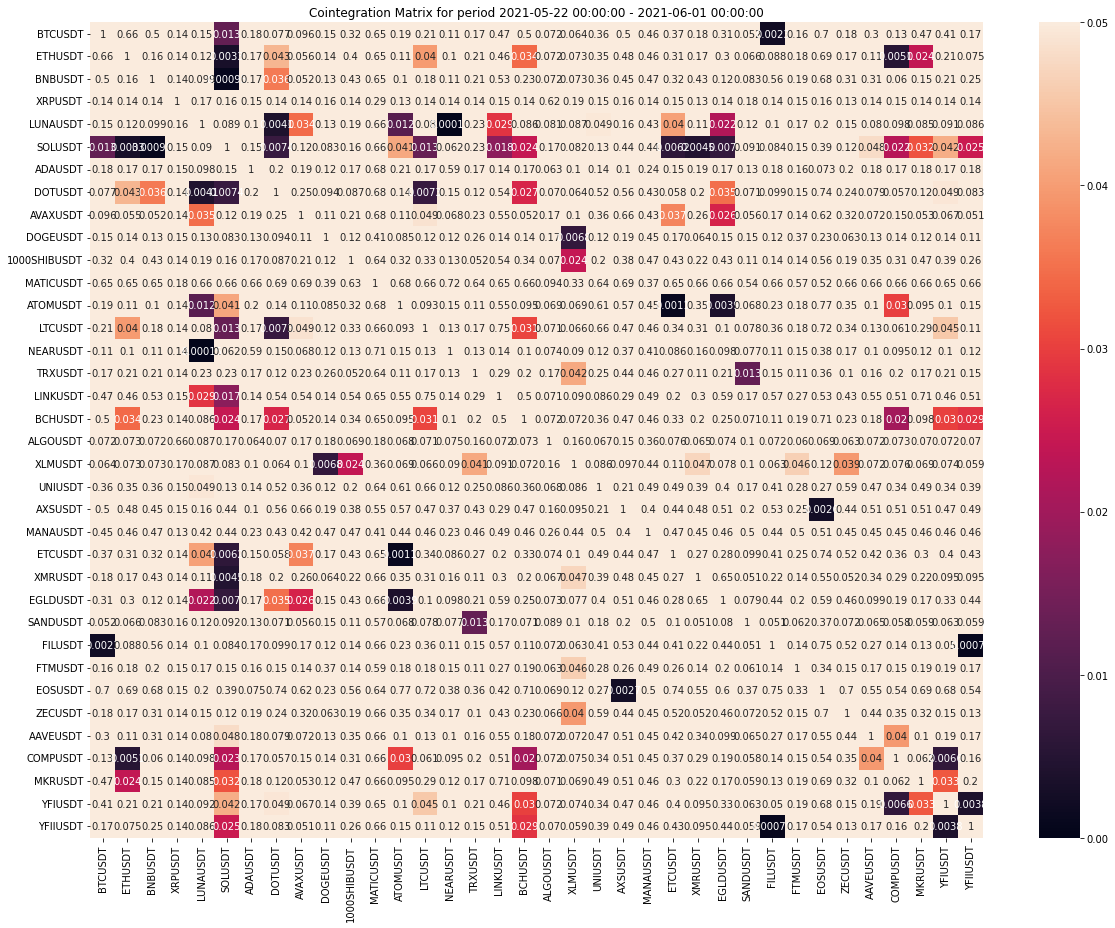

In [7]:
dates = prices_1h['BTCUSDT']['date'].reset_index()
end_date = '2021-06-01 00:00:00'
lookback_window_coint = 24 * 10
start_date = dates.iloc[dates[dates['date'] == end_date].index[0]-lookback_window_coint]['date']

coint_type = 'engle-granger'
confidence_interval = 0.95

counter = 0
total_pairs = len(assets) * len(assets) #total_pairs = int((len(selected_assets) * len(selected_assets) - len(selected_assets)) / 2)
pairs = {}
coint_matrix = pd.DataFrame(index=assets, columns=assets)
beta_matrix = pd.DataFrame(index=assets, columns=assets)
for i in range(0, len(coint_matrix)):
    data_A = prices_1h[assets[i]][prices_1h[assets[i]]['date'] > start_date]
    data_A = data_A[data_A['date'] < end_date]
    data_A['price'] = data_A['log_price']
    for j in range(0, len(coint_matrix)):
        counter += 1
        if i != j:
            data_B = prices_1h[assets[j]][prices_1h[assets[j]]['date'] > start_date]
            data_B = data_B[data_B['date'] < end_date]
            data_B['price'] = data_B['log_price']
            #print("Calculating pair {} of {}".format(counter, total_pairs))
            cointegrated, pvalue, beta = cointegration(coint_type, confidence_interval, data_A['price'], data_B['price'])
            coint_matrix[assets[i]][assets[j]] = pvalue
            beta_matrix[assets[i]][assets[j]] = beta
            pairs['{}/{}'.format(assets[i], assets[j])] = {}
            pairs['{}/{}'.format(assets[i], assets[j])]['pvalue'] = pvalue
            pairs['{}/{}'.format(assets[i], assets[j])]['beta'] = beta
            

coint_matrix = coint_matrix.astype(float).fillna(1)
beta_matrix = beta_matrix.astype(float)
pairs_df = pd.DataFrame(pairs)

# Show
plt.figure(figsize=(20,15))
plt.title('Cointegration Matrix for period {} - {}'.format(start_date, end_date))
sb.heatmap(coint_matrix, annot=True, vmin=0, vmax=0.05)

### Forward test cointegrated pairs and find optimal lookback window and std multiple

In [8]:
# For now, when choosing start date, you must overlap the zscore lookback period with the cointegration test period
# for example, i did coint test on a 30 days period, i want to forward test with rolling window of 14, start date
# must be last day of coint test minus 14
forwardtest_start_date = '2021-05-21 00:00:00'
forwardtest_end_date = '2021-06-19 00:00:00'
lookback_window = 24 * 10
cointegrated_pairs_df = pairs_df.T[pairs_df.T['pvalue'] <= 0.05]
returns = []
fees_paid = []
max_drawdown = []
nbr_of_trades = []
returns_per_dd = []

for pair in cointegrated_pairs_df.index:

    pair_asset_a, pair_asset_b = pair.split('/')

    pair_price_a = prices_1h[pair_asset_a][prices_1h[pair_asset_a]['date'] > forwardtest_start_date]
    pair_price_a = pair_price_a[pair_price_a['date'] < forwardtest_end_date]

    pair_price_b = prices_1h[pair_asset_b][prices_1h[pair_asset_b]['date'] > forwardtest_start_date]
    pair_price_b = pair_price_b[pair_price_b['date'] < forwardtest_end_date]
    dates = pair_price_a['date']
    
    fees = 0.0006
    rolling_window = lookback_window
    std_multiple = 1.5
    start_capital = 10000.0
    order_size_pct = 1
    beta = 1
    
    positions, capital, commission, zscore = zscore_mean_reversion_strategy(pair_price_a['price'], pair_price_b['price'], rolling_window, std_multiple, fees, start_capital, order_size_pct, beta)
    # Nbr of trades
    trades = 0
    current_pos = 0
    for i in positions:
        if i != current_pos:
            trades += 1
            current_pos = i
    
    # Max drawdown calculation
    dd_i = np.argmax(np.maximum.accumulate(capital) - capital) # end of the period
    if dd_i > 0:
        dd_j = np.argmax(capital[:dd_i]) # start of period
        max_dd = (capital[dd_i]-capital[dd_j])/capital[dd_i]*100
    else:
        max_dd = 0
    
    returns.append((list(capital)[-1]/list(capital)[0]-1)*(1-commission)*100)
    fees_paid.append(commission * 100)
    max_drawdown.append(max_dd)
    nbr_of_trades.append(trades)
    
    
cointegrated_pairs_df['returns_pct'] = returns
cointegrated_pairs_df['fees_paid_pct'] = fees_paid
cointegrated_pairs_df['max_drawdown_pct'] = max_drawdown
cointegrated_pairs_df['nbr_of_trades'] = nbr_of_trades
cointegrated_pairs_df['returns_per_drawdown'] = list(pd.Series(returns) / pd.Series(max_drawdown).abs())

cointegrated_pairs_df.sort_values(['returns_per_drawdown'], ascending=False)[:10]

,pvalue,beta,returns_pct,fees_paid_pct,max_drawdown_pct,nbr_of_trades,returns_per_drawdown
TRXUSDT/SANDUSDT,0.012931,2.205395,11.153379,0.239784,-1.405034,4,7.938157
DOTUSDT/BNBUSDT,0.035943,0.527762,14.091879,0.836732,-2.387367,14,5.902687
DOTUSDT/LTCUSDT,0.007349,0.591274,13.564382,0.478993,-2.321509,8,5.842915
BNBUSDT/DOTUSDT,0.035943,1.894266,12.072534,0.836732,-2.102241,14,5.742697
LTCUSDT/DOTUSDT,0.007339,1.690867,13.069719,0.478993,-2.321509,8,5.629837
LUNAUSDT/NEARUSDT,0.000147,1.628052,22.050915,0.717629,-4.237744,12,5.203455
NEARUSDT/LUNAUSDT,0.000149,0.613272,21.250155,0.717629,-4.210903,12,5.046461
DOTUSDT/YFIUSDT,0.049387,0.286327,9.246682,0.299640,-2.626538,5,3.520483
SANDUSDT/TRXUSDT,0.012940,0.451713,9.063089,0.299640,-2.598865,5,3.487326
YFIUSDT/DOTUSDT,0.049379,3.490913,8.572181,0.299640,-2.542884,5,3.371047


### Cointegrated pair with the best returns

Returns: 35.99%
Fees paid: 0.30%
Max Drawdown: -4.44%


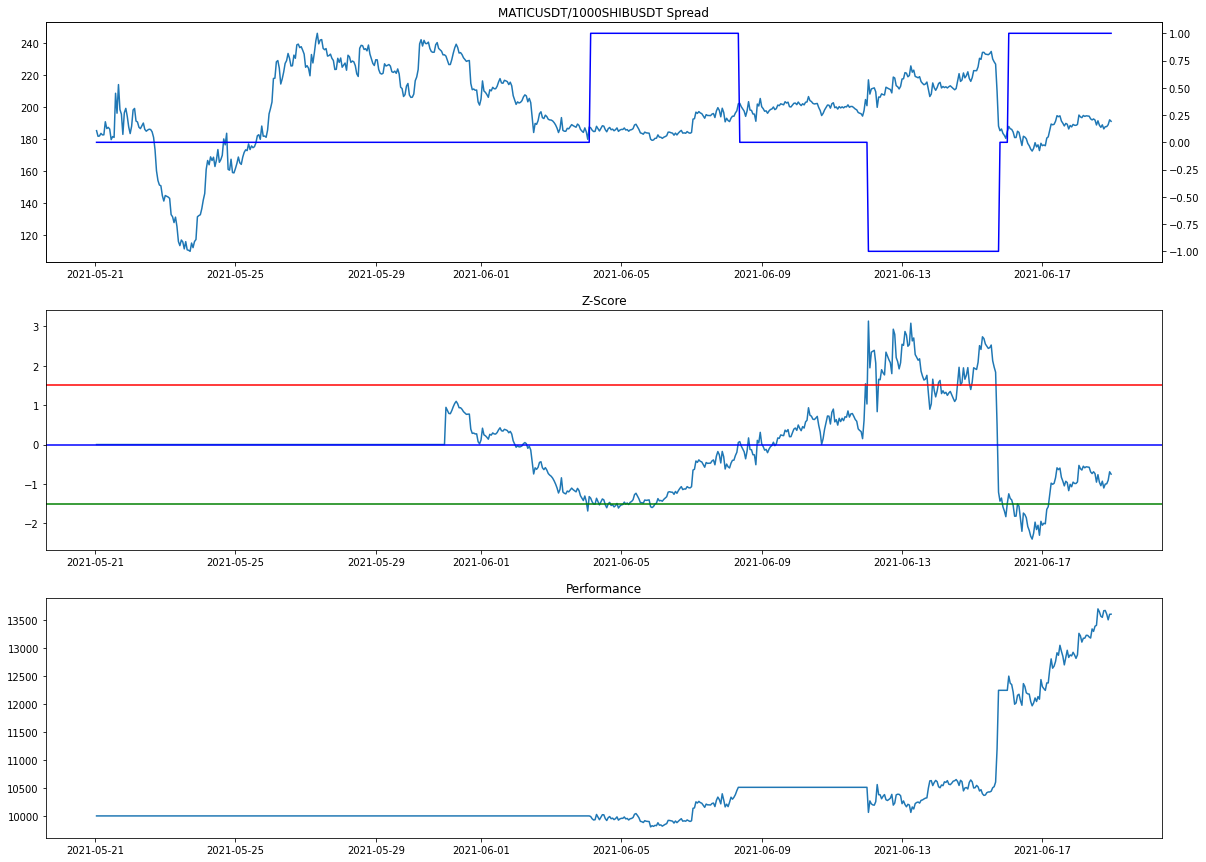

In [9]:
pair_asset_a = 'MATICUSDT'
pair_asset_b = '1000SHIBUSDT'

pair_price_a = prices_1h[pair_asset_a][prices_1h[pair_asset_a]['date'] > forwardtest_start_date]
pair_price_a = pair_price_a[pair_price_a['date'] < forwardtest_end_date]
pair_price_b = prices_1h[pair_asset_b][prices_1h[pair_asset_b]['date'] > forwardtest_start_date]
pair_price_b = pair_price_b[pair_price_b['date'] < forwardtest_end_date]
dates = pair_price_a['date']

fees = 0.0006
rolling_window = lookback_window
std_multiple = 1.5
start_capital = 10000.0
order_size_pct = 1
beta = 1
positions, capital, fees_paid, zscore = zscore_mean_reversion_strategy(pair_price_a['price'], pair_price_b['price'], rolling_window, std_multiple, fees, start_capital, order_size_pct, beta)

# Max drawdown calculation
dd_i = np.argmax(np.maximum.accumulate(capital) - capital) # end of the period
if dd_i > 0:
    dd_j = np.argmax(capital[:dd_i]) # start of period
    max_dd = (capital[dd_i]-capital[dd_j])/capital[dd_i]*100
else:
    max_dd = 0

# Visualization
fig, axs = plt.subplots(3, figsize=(20,15))
fig.figsize=(20,15)
axs[0].plot(dates, pair_price_a['price']/pair_price_b['price'])
axs[0].title.set_text('{}/{} Spread'.format(pair_asset_a,pair_asset_b))
axs0_2 = axs[0].twinx()
axs0_2.plot(dates, positions, color='b')
axs[1].plot(dates, zscore)
axs[1].title.set_text('Z-Score')
axs[1].axhline(std_multiple, color='r')
axs[1].axhline(-std_multiple, color='g')
axs[1].axhline(0, color='b')
axs[2].plot(dates, capital)
axs[2].title.set_text('Performance')

print('Returns: {:.2f}%'.format((list(capital)[-1]/list(capital)[0]-1)*100*(1-fees_paid)))
print('Fees paid: {:.2f}%'.format(fees_paid*100))
print('Max Drawdown: {:.2f}%'.format(max_dd))

### Optimize lookback windows and STD multiples

In [35]:
# Note: Lookback period is used to determine which pairs are cointegrated 
# and lookforward periods are used as the rolling cointegration window in the forward testing
dates = prices_1h['BTCUSDT']['date'].reset_index()
end_date = '2021-06-01 00:00:00'

forwardtest_start_date = '2021-05-21 00:00:00'
forwardtest_end_date = '2021-06-19 00:00:00'

lookback_periods = range(24, 24*14, 12)
lookforward_periods = range(24, 24*14, 12)

optimization_matrix = pd.DataFrame(index=lookback_periods, columns=lookforward_periods)

coint_type = 'engle-granger'
confidence_interval = 0.95

for lb in optimization_matrix.index:
    print(lb)
    start_date = dates.iloc[dates[dates['date'] == end_date].index[0]-lb]['date']

    counter = 0
    total_pairs = len(assets) * len(assets) #total_pairs = int((len(selected_assets) * len(selected_assets) - len(selected_assets)) / 2)
    pairs = {}
    coint_matrix = pd.DataFrame(index=assets, columns=assets)
    beta_matrix = pd.DataFrame(index=assets, columns=assets)
    for i in range(0, len(coint_matrix)):
        data_A = prices_1h[assets[i]][prices_1h[assets[i]]['date'] > start_date]
        data_A = data_A[data_A['date'] < end_date]
        data_A['price'] = data_A['log_price']
        for j in range(0, len(coint_matrix)):
            counter += 1
            if i != j:
                data_B = prices_1h[assets[j]][prices_1h[assets[j]]['date'] > start_date]
                data_B = data_B[data_B['date'] < end_date]
                data_B['price'] = data_B['log_price']
                #print("Calculating pair {} of {}".format(counter, total_pairs))
                cointegrated, pvalue, beta = cointegration(coint_type, confidence_interval, data_A['price'], data_B['price'])
                coint_matrix[assets[i]][assets[j]] = pvalue
                beta_matrix[assets[i]][assets[j]] = beta
                pairs['{}/{}'.format(assets[i], assets[j])] = {}
                pairs['{}/{}'.format(assets[i], assets[j])]['pvalue'] = pvalue
                pairs['{}/{}'.format(assets[i], assets[j])]['beta'] = beta
    
    coint_matrix = coint_matrix.astype(float).fillna(1)
    beta_matrix = beta_matrix.astype(float)
    pairs_df = pd.DataFrame(pairs)
    cointegrated_pairs_df = pairs_df.T[pairs_df.T['pvalue'] <= 0.05]

    # Forward Testing of strategy
    for lf in optimization_matrix.columns:
        
        returns = []
        fees_paid = []
        max_drawdown = []
        nbr_of_trades = []
        returns_per_dd = []

        for pair in cointegrated_pairs_df.index:

            pair_asset_a, pair_asset_b = pair.split('/')

            pair_price_a = prices_1h[pair_asset_a][prices_1h[pair_asset_a]['date'] > forwardtest_start_date]
            pair_price_a = pair_price_a[pair_price_a['date'] < forwardtest_end_date]

            pair_price_b = prices_1h[pair_asset_b][prices_1h[pair_asset_b]['date'] > forwardtest_start_date]
            pair_price_b = pair_price_b[pair_price_b['date'] < forwardtest_end_date]
            #dates = pair_price_a['date']

            fees = 0.0006
            rolling_window = lf
            std_multiple = 1.5
            start_capital = 10000.0
            order_size_pct = 1
            beta = 1

            positions, capital, commission, zscore = zscore_mean_reversion_strategy(pair_price_a['price'], pair_price_b['price'], rolling_window, std_multiple, fees, start_capital, order_size_pct, beta)
            # Nbr of trades
            trades = 0
            current_pos = 0
            for i in positions:
                if i != current_pos:
                    trades += 1
                    current_pos = i

            # Max drawdown calculation
            dd_i = np.argmax(np.maximum.accumulate(capital) - capital) # end of the period
            if dd_i > 0:
                dd_j = np.argmax(capital[:dd_i]) # start of period
                max_dd = (capital[dd_i]-capital[dd_j])/capital[dd_i]*100
            else:
                max_dd = 0

            returns.append((list(capital)[-1]/list(capital)[0]-1)*(1-commission)*100)
            fees_paid.append(commission * 100)
            max_drawdown.append(max_dd)
            nbr_of_trades.append(trades)


        cointegrated_pairs_df['returns_pct'] = returns
        cointegrated_pairs_df['fees_paid_pct'] = fees_paid
        cointegrated_pairs_df['max_drawdown_pct'] = max_drawdown
        cointegrated_pairs_df['nbr_of_trades'] = nbr_of_trades
        cointegrated_pairs_df['returns_per_drawdown'] = list(pd.Series(returns) / pd.Series(max_drawdown).abs())

        best_pairs = cointegrated_pairs_df.sort_values(['returns_per_drawdown'], ascending=False)[:10]
        
        optimization_matrix.loc[lb][lf] = best_pairs['returns_per_drawdown'].median()

24
36
48
60
72
84
96
108
120
132
144
156
168
180
192
204
216
228
240
252
264
276
288
300
312
324


[Text(0.5, 114.0, 'Lookback Cointegration'),
 Text(159.0, 0.5, 'Lookforward Rolling Window')]

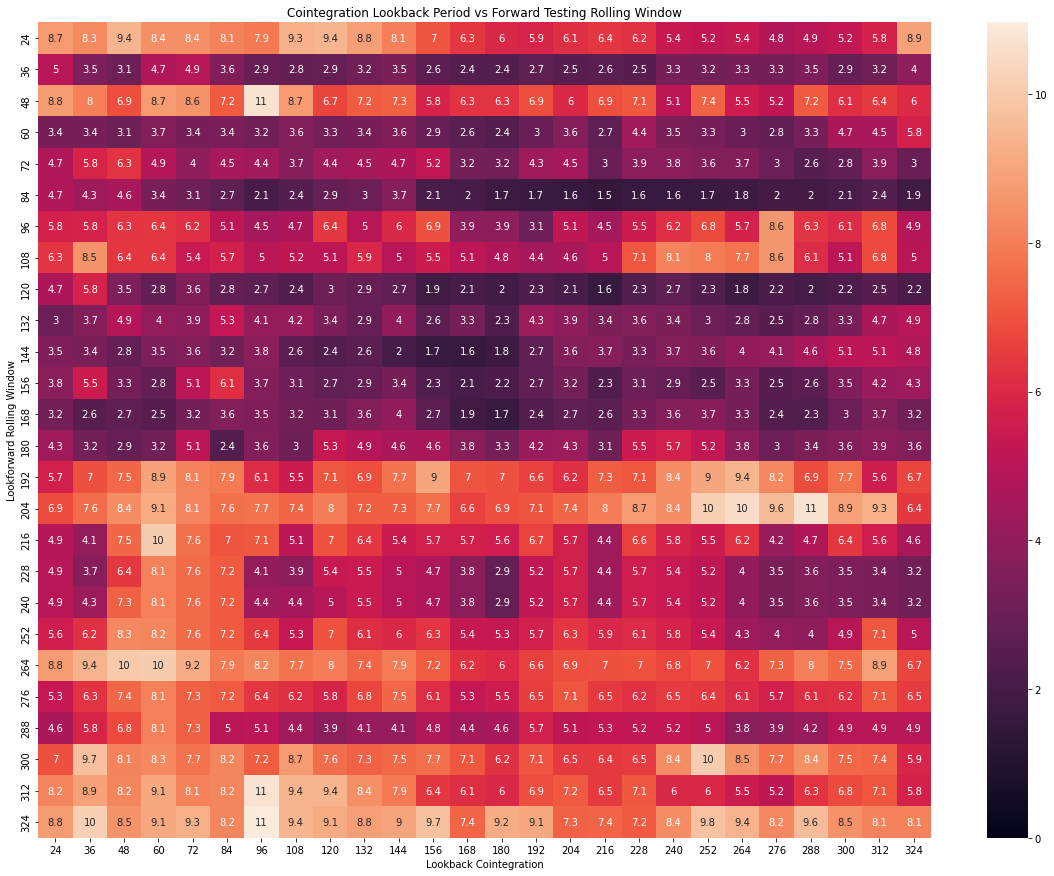

In [45]:
# Show
max_value = optimization_matrix.max().max()
plt.figure(figsize=(20,15))
plt.title('Cointegration Lookback Period vs Forward Testing Rolling Window')
hm = sb.heatmap(optimization_matrix.astype(float), annot=True, vmin=0, vmax=max_value)
hm.set(xlabel='Lookback Cointegration', ylabel='Lookforward Rolling Window')

In [20]:
end_date

'2021-06-01 00:00:00'

In [165]:
(capital[i]-capital[j])/capital[i]*100

-1.9217441295036521

In [209]:
for i in np.arange(1,3,0.2):
    print(i)

1.0
1.2
1.4
1.5999999999999999
1.7999999999999998
1.9999999999999998
2.1999999999999997
2.3999999999999995
2.5999999999999996
2.8


In [24]:
end_date

'2021-06-01 00:00:00'

In [29]:
dates.loc[403]

Timestamp('2021-06-01 00:00:00')

In [34]:
dates['date']

KeyError: 'date'